In [1]:
# -*- coding: utf-8 -*-
"""
# 📰 News Headline Classifier - Complete Implementation

**Objetivo:** Clasificar titulares de noticias usando múltiples enfoques de ML/LLM

**Modelos a probar:**
1. TF-IDF + Logistic Regression (baseline)
2. Sentence-Transformers + Random Forest (moderno)
3. Gemma LLM via Ollama (innovador)

**Dataset:** data.json con campos 'headline' y 'category'
"""

# ==================== 1. SETUP E INSTALACIONES ====================

# TODO --> Mis dependecias a utilizar
!pip install -q sentence-transformers scikit-learn pandas matplotlib seaborn plotly
!pip install -q wordcloud tqdm ollama requests
!curl -fsSL https://ollama.ai/install.sh | sh
!nohup ollama serve &
import time
time.sleep(5)  # Esperar a que se inicie Ollama
!ollama pull gemma:2b

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sentence_transformers import SentenceTransformer
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


np.random.seed(42)
plt.style.use('default')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.9 MB/s eta 0:00:00
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user t

In [3]:
# ==================== 2. CARGA Y EDA DE DATOS ====================

def load_and_explore_data(file_path='/content/data.json'):
    """
    Esto sirve para cargar mi dataset y realizar mi analisis exploratirio
    Args:
        file_path (str): JSON con los datos "data.json"

    Returns:
        pd.DataFrame: DataFrame con los datos cargados
    """
    # Cargar datos
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    df = pd.DataFrame(data)

    print(f"Dataset con: {len(df)} registros")
    print(f"Columnas: {list(df.columns)}")
    print(f"Categorías únicas: {df['category'].nunique()}")

    print("\n" + "="*50)
    print("INFORME")
    print("="*50)
    print(df.info())

    print("\n" + "="*50)
    print("DISTRIBUCIÓN DE CATEGORÍAS")
    print("="*50)
    category_counts = df['category'].value_counts()
    print(category_counts)

    # Estadísticas de texto
    df['headline_length'] = df['headline'].str.len()
    df['word_count'] = df['headline'].str.split().str.len()

    print("\n" + "="*50)
    print("ESTADÍSTICAS DE TEXTO")
    print("="*50)
    print(f"Longitud promedio: {df['headline_length'].mean():.1f} caracteres")
    print(f"Palabras promedio: {df['word_count'].mean():.1f} palabras")

    # primeras visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # categorías
    category_counts.plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Distribución de Categorías')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Longitud de titulares
    df['headline_length'].hist(bins=30, ax=axes[0,1])
    axes[0,1].set_title('Distribución de Longitud de Titulares')
    axes[0,1].set_xlabel('Caracteres')

    # Número de palabras
    df['word_count'].hist(bins=20, ax=axes[1,0])
    axes[1,0].set_title('Distribución de Número de Palabras')
    axes[1,0].set_xlabel('Palabras')

    # longitud por categoría
    df.boxplot(column='headline_length', by='category', ax=axes[1,1])
    axes[1,1].set_title('Longitud por Categoría')
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return df

In [4]:
# ==================== 3. PREPROCESAMIENTO ====================

def preprocess_text(text):
    """
    Esta funcion sirve para el prepocesmiento clasificatorio.
    Args:
        text (str): Texto a preprocesar

    Returns:
        str: Texto limpio
    """
    if pd.isna(text):
        return ""


    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = ' '.join(text.split())

    return text

def prepare_data(df):
    """
    Preparacion de los datps para entrenar

    Args:
        df (pd.DataFrame):  datos originales

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """

    df['headline_clean'] = df['headline'].apply(preprocess_text)

    X = df['headline_clean']
    y = df['category']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f" Datos preparados:")
    print(f"   Entrenamiento: {len(X_train)} muestras")
    print(f"   Prueba: {len(X_test)} muestras")
    print(f"   Categorías: {len(y.unique())}")

    return X_train, X_test, y_train, y_test

In [5]:
# ==================== 4. MODELO 1: TF-IDF + LOGISTIC REGRESSION ====================

class TfidfClassifier:
    """Clasificador usando TF-IDF + Logistic Regression."""

    def __init__(self):
        self.vectorizer = TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            stop_words='english',
            min_df=2,
            max_df=0.95
        )
        self.model = LogisticRegression(random_state=42, max_iter=1000)
        self.is_trained = False

    def train(self, X_train, y_train):
        """Esta funcion entrena el modelo TF-IDF."""
        print("Entrenando modelo TF-IDF...")

        X_tfidf = self.vectorizer.fit_transform(X_train)

        self.model.fit(X_tfidf, y_train)
        self.is_trained = True

        print("Modelo TF-IDF entrenado")

    def predict(self, X_test):
        """Realiza predicciones."""
        if not self.is_trained:
            raise ValueError("Modelo no entrenado")

        X_tfidf = self.vectorizer.transform(X_test)
        predictions = self.model.predict(X_tfidf)
        probabilities = self.model.predict_proba(X_tfidf)

        return predictions, probabilities

    def predict_single(self, headline):
        """Predice una sola muestra."""
        if not self.is_trained:
            raise ValueError("Modelo no entrenado")

        clean_headline = preprocess_text(headline)
        X_tfidf = self.vectorizer.transform([clean_headline])
        prediction = self.model.predict(X_tfidf)[0]
        probabilities = self.model.predict_proba(X_tfidf)[0]

        # Crear diccionario de probabilidades
        prob_dict = dict(zip(self.model.classes_, probabilities))

        return {
            'category': prediction,
            'confidence': max(probabilities),
            'probabilities': prob_dict
        }

In [6]:
# ==================== 5. MODELO 2: SENTENCE TRANSFORMERS ====================

class SentenceTransformerClassifier:
    """Clasificador usando Sentence-Transformers + Random Forest."""

    def __init__(self):
        print("📥 Cargando Sentence-Transformer...")
        self.encoder = SentenceTransformer('all-MiniLM-L6-v2')
        self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.is_trained = False
        print("Sentence-Transformer cargado")

    def train(self, X_train, y_train):
        """Entrena el modelo con embeddings."""
        print("Generando embeddings...")

        embeddings = self.encoder.encode(X_train.tolist(), show_progress_bar=True)

        print("🚀 Entrenando Random Forest...")
        self.model.fit(embeddings, y_train)
        self.is_trained = True

        print("Modelo Sentence-Transformer entrenado")

    def predict(self, X_test):
        """Realiza predicciones."""
        if not self.is_trained:
            raise ValueError("Modelo no entrenado")

        embeddings = self.encoder.encode(X_test.tolist(), show_progress_bar=True)
        predictions = self.model.predict(embeddings)
        probabilities = self.model.predict_proba(embeddings)

        return predictions, probabilities

    def predict_single(self, headline):
        """Predice una sola muestra."""
        if not self.is_trained:
            raise ValueError("Modelo no entrenado")

        clean_headline = preprocess_text(headline)
        embedding = self.encoder.encode([clean_headline])
        prediction = self.model.predict(embedding)[0]
        probabilities = self.model.predict_proba(embedding)[0]

        prob_dict = dict(zip(self.model.classes_, probabilities))

        return {
            'category': prediction,
            'confidence': max(probabilities),
            'probabilities': prob_dict
        }

In [7]:
# ==================== 6. MODELO 3: GEMMA LLM ====================

import ollama

class GemmaClassifier:
    """Clasificador usando Gemma LLM."""

    def __init__(self, categories):
        self.categories = categories
        self.is_trained = True  # LLM no necesita entrenamiento

    def create_prompt(self, headline):
        """Esta funcion tiene mi prompt en ingles para mi clssificacion."""
        categories_str = ", ".join(self.categories)

        prompt = f"""Classify this news headline into ONE of these categories: {categories_str}

Headline: "{headline}"

Respond with ONLY the category name from the list above. Nothing else.

Examples:
- "Breaking: Major earthquake hits California" → U.S. NEWS
- "23 Funniest Tweets About Cats This Week" → COMEDY
- "Tips for helping toddler sleep better" → PARENTING

Category:"""

        return prompt

    def predict_single(self, headline):
        """Gemma."""
        try:
            prompt = self.create_prompt(headline)

            response = ollama.generate(
                model='gemma:2b',
                prompt=prompt,
                options={
                    'temperature': 0.1,
                    'top_p': 0.9,
                    'num_predict': 10
                }
            )

            predicted_category = response['response'].strip().upper()

            if predicted_category not in self.categories:
                predicted_category = self._find_closest_category(predicted_category)

            return {
                'category': predicted_category,
                'confidence': 0.85,
                'probabilities': {predicted_category: 0.85}
            }

        except Exception as e:
            print(f"❌ Error con Gemma: {e}")
            return {
                'category': 'U.S. NEWS',
                'confidence': 0.5,
                'probabilities': {'U.S. NEWS': 0.5}
            }

    def _find_closest_category(self, prediction):
        """Encuentra la categoría más cercana."""
        prediction_lower = prediction.lower()

        if 'news' in prediction_lower:
            if 'u.s' in prediction_lower or 'us' in prediction_lower:
                return 'U.S. NEWS'
            else:
                return 'WORLD NEWS'
        elif 'comedy' in prediction_lower or 'funny' in prediction_lower:
            return 'COMEDY'
        elif 'parent' in prediction_lower:
            return 'PARENTING'
        elif 'sport' in prediction_lower:
            return 'SPORTS'
        elif 'business' in prediction_lower:
            return 'BUSINESS'
        else:
            return 'U.S. NEWS'  # Default


In [8]:
# ==================== 7. EVALUACIÓN ====================

def evaluate_model(model, X_test, y_test, model_name):
    """
    Esta funcion sirve para evaluar el modelo y generar metricas o insights

    Args:
        model: Modelo entrenado
        X_test: Datos de prueba
        y_test: Etiquetas reales
        model_name: Nombre del modelo
    """
    print(f"\n{'='*50}")
    print(f"EVALUACIÓN: {model_name}")
    print(f"{'='*50}")

    if hasattr(model, 'predict'):
        predictions, probabilities = model.predict(X_test)
    else:
        predictions = []
        for headline in X_test:
            pred = model.predict_single(headline)
            predictions.append(pred['category'])
        predictions = np.array(predictions)

    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy:.4f}")

    print(f"Reporte de Clasificaicon:")
    print(classification_report(y_test, predictions))

    cm = confusion_matrix(y_test, predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return accuracy

In [9]:
# ==================== 8. FUNCIÓN PRINCIPAL DE PREDICCIÓN ====================

def predict_headline(headline, models_dict):
    """
    Predice la categoría de un titular usando múltiples modelos.

    Args:
        headline (str): Titular a clasificar
        models_dict (dict): Diccionario con modelos entrenados

    Returns:
        dict: Predicciones de todos los modelos
    """
    print(f"\nClasificando: '{headline}'")
    print("="*60)

    results = {}

    for model_name, model in models_dict.items():
        try:
            result = model.predict_single(headline)
            results[model_name] = result

            print(f"{model_name}:")
            print(f"    Categoría: {result['category']}")
            print(f"    Confianza: {result['confidence']:.3f}")

        except Exception as e:
            print(f" Error en {model_name}: {e}")
            results[model_name] = {'category': 'ERROR', 'confidence': 0.0}

    return results

🚀 INICIANDO NEWS CLASSIFIER
📊 Dataset cargado: 209527 registros
📋 Columnas: ['headline', 'category']
🏷️  Categorías únicas: 42

INFORMACIÓN BÁSICA
<class 'pandas.core.frame.DataFrame'>
Index: 209527 entries, 0 to 209526
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   headline  209527 non-null  object
 1   category  209527 non-null  object
dtypes: object(2)
memory usage: 4.8+ MB
None

DISTRIBUCIÓN DE CATEGORÍAS
category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD 

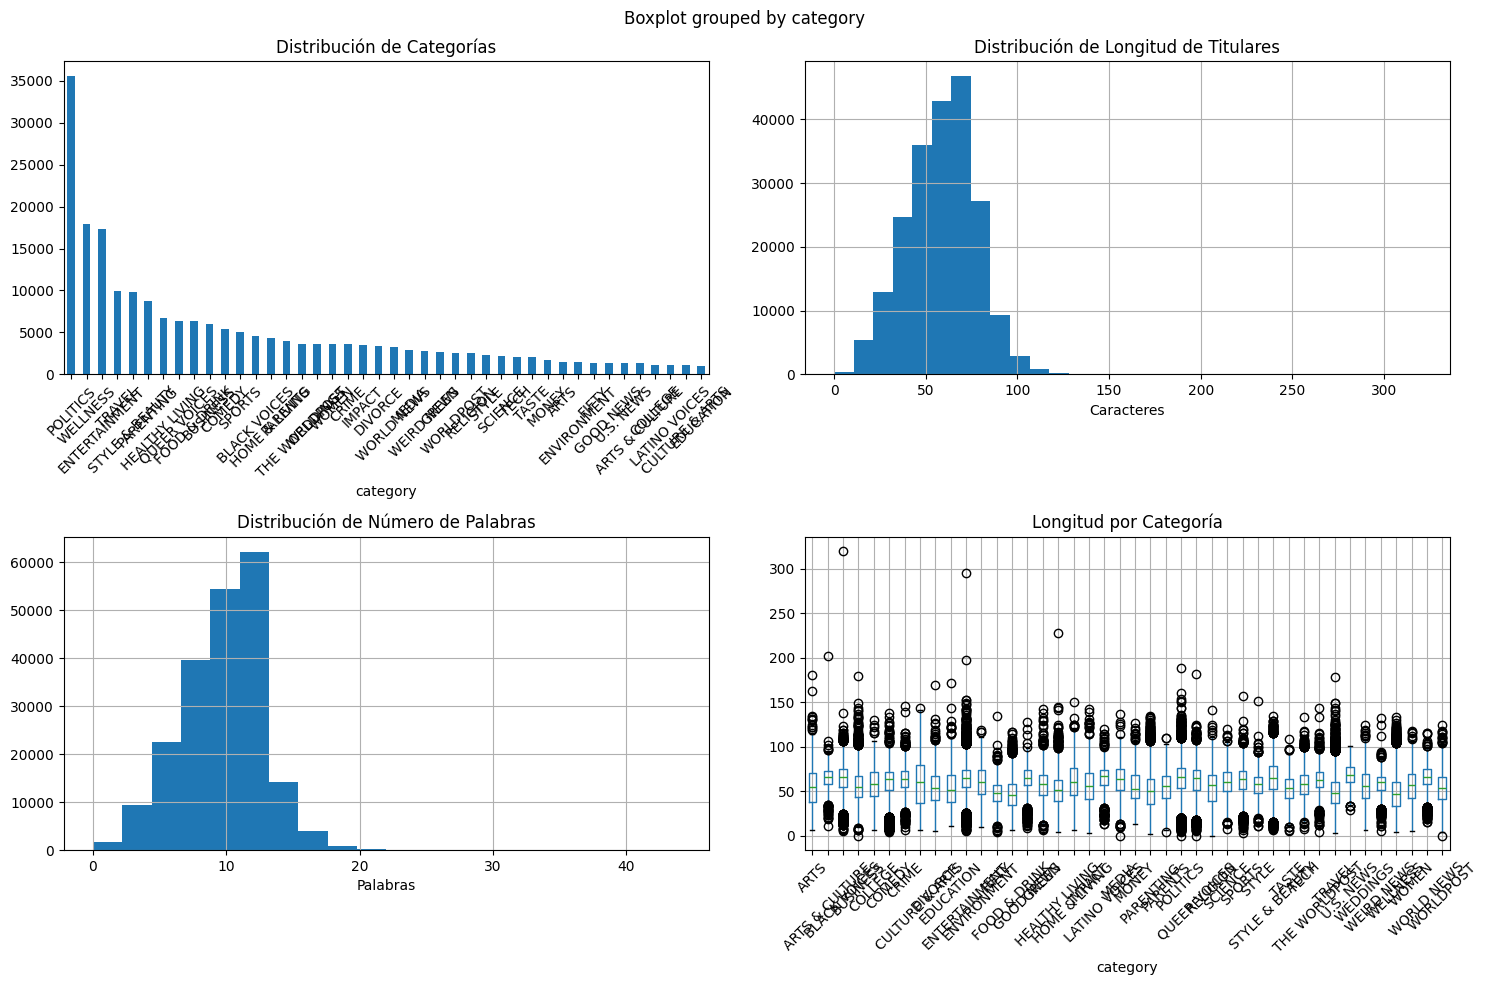

✅ Datos preparados:
   📚 Entrenamiento: 167621 muestras
   🧪 Prueba: 41906 muestras
   🏷️  Categorías: 42

ENTRENANDO MODELOS
🚀 Entrenando modelo TF-IDF...
✅ Modelo TF-IDF entrenado
📥 Cargando Sentence-Transformer...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Sentence-Transformer cargado
🚀 Generando embeddings...


Batches:   0%|          | 0/5239 [00:00<?, ?it/s]

🚀 Entrenando Random Forest...
✅ Modelo Sentence-Transformer entrenado

EVALUACIÓN: TF-IDF + LogReg
🎯 Accuracy: 0.5484

📊 Classification Report:
                precision    recall  f1-score   support

          ARTS       0.41      0.17      0.24       302
ARTS & CULTURE       0.35      0.11      0.17       268
  BLACK VOICES       0.47      0.31      0.37       917
      BUSINESS       0.46      0.40      0.42      1198
       COLLEGE       0.46      0.31      0.37       229
        COMEDY       0.59      0.40      0.48      1080
         CRIME       0.52      0.50      0.51       712
CULTURE & ARTS       0.70      0.23      0.34       215
       DIVORCE       0.79      0.59      0.68       685
     EDUCATION       0.44      0.23      0.30       203
 ENTERTAINMENT       0.53      0.70      0.61      3473
   ENVIRONMENT       0.57      0.18      0.27       289
         FIFTY       0.43      0.12      0.18       280
  FOOD & DRINK       0.58      0.61      0.60      1268
     GOOD NEWS 

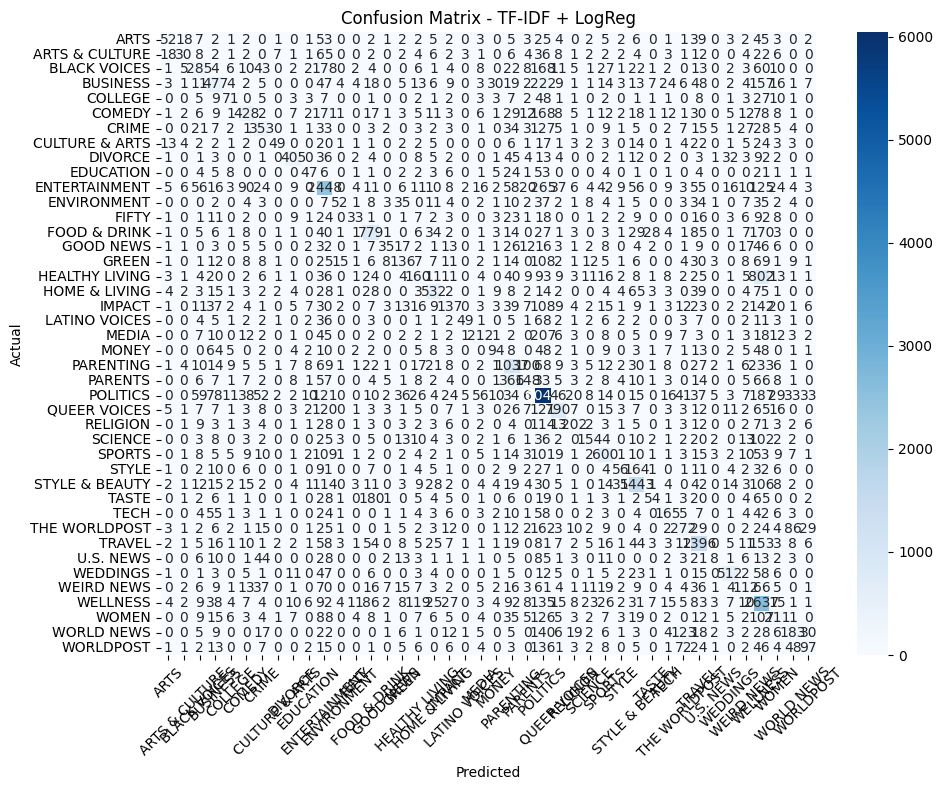


EVALUACIÓN: Sentence-Transformers


Batches:   0%|          | 0/1310 [00:00<?, ?it/s]

🎯 Accuracy: 0.4643

📊 Classification Report:
                precision    recall  f1-score   support

          ARTS       0.00      0.00      0.00       302
ARTS & CULTURE       0.00      0.00      0.00       268
  BLACK VOICES       0.66      0.06      0.11       917
      BUSINESS       0.51      0.16      0.24      1198
       COLLEGE       0.75      0.04      0.07       229
        COMEDY       0.59      0.06      0.10      1080
         CRIME       0.58      0.22      0.32       712
CULTURE & ARTS       0.82      0.04      0.08       215
       DIVORCE       0.81      0.45      0.58       685
     EDUCATION       1.00      0.01      0.02       203
 ENTERTAINMENT       0.38      0.76      0.51      3473
   ENVIRONMENT       1.00      0.08      0.15       289
         FIFTY       0.00      0.00      0.00       280
  FOOD & DRINK       0.56      0.69      0.62      1268
     GOOD NEWS       0.67      0.01      0.01       280
         GREEN       0.49      0.05      0.08       524
HE

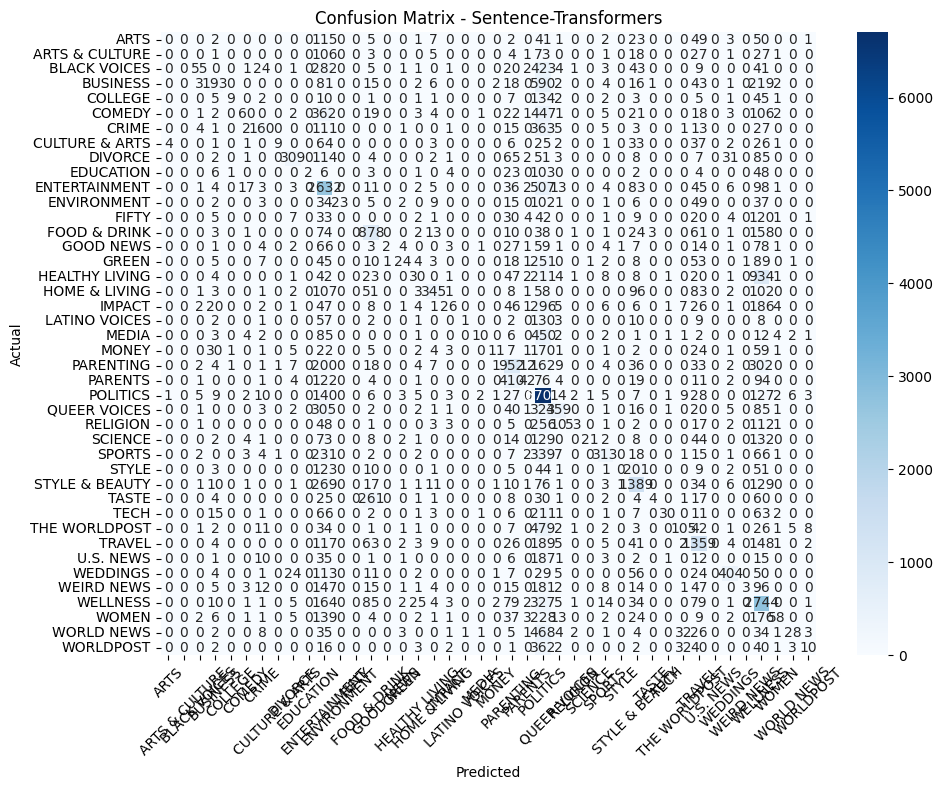


RESUMEN DE RESULTADOS
📊 TF-IDF + LogReg: 0.5484
📊 Sentence-Transformers: 0.4643

EJEMPLOS DE PREDICCIÓN

🔍 Clasificando: 'Breaking: Major earthquake hits California coast'

🤖 TF-IDF + LogReg:
   📂 Categoría: GREEN
   🎯 Confianza: 0.343

🤖 Sentence-Transformers:
   📂 Categoría: POLITICS
   🎯 Confianza: 0.130

🤖 Gemma LLM:
   📂 Categoría: U.S. NEWS
   🎯 Confianza: 0.850

🔍 Clasificando: '23 Funniest Tweets About Cats This Week'

🤖 TF-IDF + LogReg:
   📂 Categoría: COMEDY
   🎯 Confianza: 0.769

🤖 Sentence-Transformers:
   📂 Categoría: COMEDY
   🎯 Confianza: 0.400

🤖 Gemma LLM:
   📂 Categoría: COMEDY
   🎯 Confianza: 0.850

🔍 Clasificando: 'Tips for helping your toddler sleep better at night'

🤖 TF-IDF + LogReg:
   📂 Categoría: PARENTING
   🎯 Confianza: 0.433

🤖 Sentence-Transformers:
   📂 Categoría: PARENTING
   🎯 Confianza: 0.180

🤖 Gemma LLM:
   📂 Categoría: PARENTING
   🎯 Confianza: 0.850

🔍 Clasificando: 'Tesla stock soars 15% after earnings report'

🤖 TF-IDF + LogReg:
   📂 Categoría: 

In [12]:
# ==================== 9. EJECUCIÓN PRINCIPAL ====================

def main():
    """Función principal que ejecuta todo el pipeline."""

    print("🚀 INICIANDO NEWS CLASSIFIER")
    print("="*60)

    df = load_and_explore_data('/content/data.json')
    X_train, X_test, y_train, y_test = prepare_data(df)
    categories = df['category'].unique().tolist()

    print(f"\n{'='*60}")
    print("ENTRENANDO MODELOS")
    print(f"{'='*60}")

    # Modelo 1: TF-IDF
    tfidf_model = TfidfClassifier()
    tfidf_model.train(X_train, y_train)

    # Modelo 2: Sentence-Transformers
    st_model = SentenceTransformerClassifier()
    st_model.train(X_train, y_train)

    # Modelo 3: Gemma
    gemma_model = GemmaClassifier(categories)

    # 4. Evaluación de modelos
    models_dict = {
        'TF-IDF + LogReg': tfidf_model,
        'Sentence-Transformers': st_model,
        'Gemma LLM': gemma_model
    }

    accuracies = {}
    for name, model in models_dict.items():
        if name != 'Gemma LLM':  # Gemma es muy lento para evaluar todo el test set
            acc = evaluate_model(model, X_test, y_test, name)
            accuracies[name] = acc

    print(f"\n{'='*60}")
    print("RESUMEN DE RESULTADOS")
    print(f"{'='*60}")

    for model_name, accuracy in accuracies.items():
        print(f"📊 {model_name}: {accuracy:.4f}")

# 6. Aqui estoy usando un test para probar algunos headlines y checar que todo este jalando
    test_headlines = [
        "Breaking: Major earthquake hits California coast",
        "23 Funniest Tweets About Cats This Week",
        "Tips for helping your toddler sleep better at night",
        "Tesla stock soars 15% after earnings report",
        "World Cup final draws record viewership"
    ]

    print(f"\n{'='*60}")
    print("EJEMPLOS DE PREDICCIÓN")
    print(f"{'='*60}")

    for headline in test_headlines:
        predict_headline(headline, models_dict)

    return models_dict, accuracies

if __name__ == "__main__":
    models, results = main()
